In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, io
from ase.build import molecule, make_supercell
from ase.quaternions import Quaternion
from muspinsim.spinsys import SpinSystem, MuonSpinSystem
from muspinsim.spinop import DensityOperator
from muspinsim.experiment import MuonExperiment
from muspinsim.constants import MU_GAMMA
from soprano.selection import AtomSelection
from soprano.properties.linkage import Molecules
from soprano.properties.transform import Rotate
from soprano.nmr.utils import _dip_constant, _dip_tensor
from soprano.calculate.powder import ZCW, SHREWD
from soprano.data.nmr import (_get_isotope_data, _get_nmr_data, _el_iso)
from soprano.utils import periodic_bridson, minimum_periodic, minimum_supcell, supcell_gridgen
from soprano.properties.nmr.dipolar import DipolarRSS, DipolarTensor, DipolarCoupling

Supposing we write $\mathbf{r} = \mathbf{r}_0+\mathbf{\rho}$ with $\mathbf{\rho}$ small, we can expand the dipolar tensor to the second order:

$$
D = \frac{3\mathbf{r}\otimes\mathbf{r}}{r^5} -\frac{1}{r^3}\mathbf{I} \approx \frac{3\mathbf{r}_0\otimes\mathbf{r}_0}{r^5_0} -\frac{1}{r^3_0}\mathbf{I} + \frac{3}{r_0^5}(\mathbf{r}_0\otimes\mathbf{\rho}+\mathbf{\rho}\otimes\mathbf{r}_0)+3\frac{\mathbf{r}_0\cdot\mathbf{\rho}}{r_0^5}(\mathbf{I}-5\frac{\mathbf{r}_0\otimes\mathbf{r}_0}{r_0^2}) + \frac{3}{r_0^5}(\mathbf{\rho}\otimes\mathbf{\rho})-\frac{15}{r_0^7}(\mathbf{r}_0\otimes\mathbf{\rho}+\mathbf{\rho}\otimes\mathbf{r}_0)(\mathbf{r}_0\cdot\mathbf{\rho})-\frac{15}{2r_0^7}\mathbf{r}_0\otimes\mathbf{r}_0(\mathbf{\rho}\cdot\mathbf{\rho}-9\frac{(\mathbf{r}_0\cdot\mathbf{\rho})^2}{r_0^2})+\frac{3}{2r_0^5}\mathbf{I}(\mathbf{\rho}\cdot\mathbf{\rho}-5\frac{(\mathbf{r}_0\cdot\mathbf{\rho})^2}{r_0^2})
$$

When we take the average for a rotating $\rho$ for which $<\rho> = 0$, lots of these terms go to zero:

$$
<D>  \approx \frac{3\mathbf{r}_0\otimes\mathbf{r}_0}{r^5_0} -\frac{1}{r^3_0}\mathbf{I}  + \frac{3}{r_0^5}<\mathbf{\rho}\otimes\mathbf{\rho}>-\frac{15}{r_0^7}<(\mathbf{r}_0\otimes\mathbf{\rho}+\mathbf{\rho}\otimes\mathbf{r}_0)(\mathbf{r}_0\cdot\mathbf{\rho})> -\frac{15}{2r_0^7}\mathbf{r}_0\otimes\mathbf{r}_0(<\mathbf{\rho}\cdot\mathbf{\rho}>-9\frac{<(\mathbf{r}_0\cdot\mathbf{\rho})^2>}{r_0^2})+\frac{3}{2r_0^5}\mathbf{I}(<\mathbf{\rho}\cdot\mathbf{\rho}>-5\frac{<(\mathbf{r}_0\cdot\mathbf{\rho})^2>}{r_0^2})
$$


In [194]:
gH = _get_isotope_data('H', 'gamma')

def get_HH_dip_tensor(r):
    r = np.array(r).astype(float)*1e-10    
    d = _dip_constant(np.linalg.norm(r), gH, gH)
    T = _dip_tensor(d, r)
    return T*1e-3

In [195]:
r_ij_0 = np.array([2,3,0])
a_i = np.array([1,0,0])
a_j = np.array([0,1,0])
v_i = np.array([0,0.5,0.1])
v_j = np.array([0.3,0,0])

alpha = np.linspace(0, 2*np.pi,101)[:-1]
aa_mesh = np.array(np.meshgrid(alpha, alpha)).reshape((2,-1)).T
qq_mesh = [[Quaternion.from_axis_angle(a_i, aa[0]), Quaternion.from_axis_angle(a_j, aa[1])] for aa in aa_mesh]

vv_mesh = np.array([[qq[0].rotate(v_i), qq[1].rotate(v_j)] for qq in qq_mesh])
delta_mesh = vv_mesh[:,1]-vv_mesh[:,0]
r_mesh = (r_ij_0 + delta_mesh)

dip_mesh = np.array([get_HH_dip_tensor(r) for r in r_mesh])

avg_dipT = np.average(dip_mesh, axis=0)

In [208]:
delta_tens = np.average(delta_mesh[:,None,:]*delta_mesh[:,:,None], axis=0)
delta_dot = np.average(np.sum(delta_mesh**2, axis=1))
delta_r0_dot = np.average(np.sum(delta_mesh*r_ij_0, axis=1)**2)
delta_tens_dot = np.average((r_ij_0[None,:,None]*delta_mesh[:,None,:]+r_ij_0[None,None,:]*delta_mesh[:,:,None])*
           np.sum(r_ij_0[None,:]*delta_mesh, axis=1)[:,None,None], axis=0)
print(delta_tens)
print(delta_dot)
print(delta_r0_dot)

dipT0 = get_HH_dip_tensor(r_ij_0)
r0n = np.linalg.norm(r_ij_0)*1e-10
r0T = r_ij_0[:,None]*r_ij_0[None,:]

d = _dip_constant(np.linalg.norm(r_ij_0), gH, gH)
avg_dipT_2nd = (dipT0 + d*1e-20*(3*delta_tens/r0n**2 -15/r0n**4*delta_tens_dot - 15.0/(2*r0n**4)*r0T*(delta_dot-9*delta_r0_dot/r0n**2) + 
3/(2*r0n**2)*np.eye(3)*(delta_dot-5*delta_r0_dot/r0n**2)))

avg_dipT = np.where(np.isclose(avg_dipT, 0), 0, avg_dipT)
avg_dipT_2nd = np.where(np.isclose(avg_dipT_2nd, 0), 0, avg_dipT_2nd)

print(dipT0)
print(avg_dipT)
print(avg_dipT_2nd)

[[ 4.50000000e-02 -3.41393580e-19  1.28962813e-17]
 [-3.41393580e-19  1.30000000e-01  5.27251853e-18]
 [ 1.28962813e-17  5.27251853e-18  1.75000000e-01]]
0.35
1.3500000000000003
[[ 0.19713209 -3.54837767 -0.        ]
 [-3.54837767 -2.7598493  -0.        ]
 [-0.         -0.          2.56271721]]
[[ 0.13273048 -3.56764036  0.        ]
 [-3.56764036 -2.64362204  0.        ]
 [ 0.          0.          2.51089156]]
[[-4.25175431e+12 -6.37763147e+12  0.00000000e+00]
 [-6.37763147e+12 -9.56644720e+12  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.56271722e+00]]


In [209]:
delta_r0_dot

1.3500000000000003

In [197]:
d*(r0n*1e-10)**3

array([-1.20120108e-55])

In [185]:
dipT0

array([[ 0.19713209, -3.54837767, -0.        ],
       [-3.54837767, -2.7598493 , -0.        ],
       [-0.        , -0.        ,  2.56271721]])

In [175]:
delta_tens

array([[ 4.50000000e-02, -3.41393580e-19,  1.28962813e-17],
       [-3.41393580e-19,  1.30000000e-01,  5.27251853e-18],
       [ 1.28962813e-17,  5.27251853e-18,  1.75000000e-01]])

In [139]:
avg_dipT

array([[ 2.66531901e+00, -3.57172303e+00,  2.34888620e-03],
       [-3.57172303e+00, -6.43058730e+00,  6.04191213e-03],
       [ 2.34888620e-03,  6.04191213e-03,  3.76526829e+00]])

In [125]:
evals, evecs = np.linalg.eigh(avg_dipT)

D = evals[np.argmax(abs(evals))]

print(evals)
print(evals/D)
print(np.sum((np.sort(evals/D)-[-0.5, -0.5, 1])**2)**0.5)

[-7.6654644   3.76527152  3.90019289]
[ 1.        -0.4911994 -0.5088006]
0.01244592747632693


In [126]:
np.linalg.eigh(get_HH_dip_tensor(r_ij_0))

(array([-7.59706268,  3.79853134,  3.79853134]),
 array([[ 0.31622777, -0.9486833 ,  0.        ],
        [ 0.9486833 ,  0.31622777,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

<IPython.core.display.Javascript object>


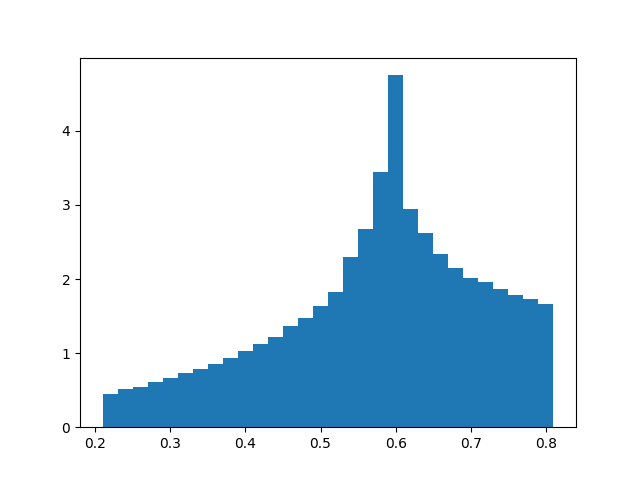

(array([0.45011371, 0.51012887, 0.54513771, 0.60515287, 0.66516803,
        0.73018446, 0.78519836, 0.85021478, 0.930235  , 1.03026026,
        1.12028301, 1.22030827, 1.37034618, 1.48037397, 1.6404144 ,
        1.82546115, 2.29557991, 2.67567593, 3.44587049, 4.75120024,
        2.95074542, 2.62566329, 2.34059128, 2.14554201, 2.02051042,
        1.955494  , 1.86547125, 1.78545104, 1.73043714, 1.66542072]),
 array([0.21002232, 0.23001727, 0.25001221, 0.27000716, 0.29000211,
        0.30999706, 0.329992  , 0.34998695, 0.3699819 , 0.38997685,
        0.40997179, 0.42996674, 0.44996169, 0.46995664, 0.48995158,
        0.50994653, 0.52994148, 0.54993643, 0.56993138, 0.58992632,
        0.60992127, 0.62991622, 0.64991117, 0.66990611, 0.68990106,
        0.70989601, 0.72989096, 0.7498859 , 0.76988085, 0.7898758 ,
        0.80987075]),
 <a list of 30 Patch objects>)

In [127]:
fig, ax = plt.subplots()

ax.hist(np.linalg.norm(delta_mesh, axis=1), bins=30, density=True)

In [128]:
np.average(delta_mesh, axis=0)

array([ 0.003, -0.005, -0.001])

In [129]:
print(np.average(np.sum(delta_mesh**2, axis=1)), np.dot(v_i, v_i)+np.dot(v_j, v_j))

0.35 0.35


In [150]:
print(np.average(np.sum(delta_mesh*r_ij_0[None,:], axis=1)**2))

1.22616


In [131]:
np.average(np.sum(vv_mesh[:,0]*r_ij_0, axis=1)), np.dot(np.average(vv_mesh[:,0], axis=0), r_ij_0)

(0.014999999999999989, 0.015000000000000124)

In [133]:
a_ii = a_i[:,None]*a_i[None,:]
a_iX = np.array([[0, -a_i[2], a_i[1]], [a_i[2], 0, -a_i[0]], [-a_i[1], a_i[0], 0]])

In [151]:
np.average(np.sum(vv_mesh[:,0]*r_ij_0, axis=1)**2), 0.5*(np.dot(r_ij_0, v_i)**2+np.linalg.multi_dot([r_ij_0, a_iX, v_i])**2)

(1.1808, 1.17)